In [42]:
import numpy as np
import pylab as plt
import torch
from tqdm.auto import tqdm
import scipy.linalg
import pandas as pd
import torchvision.datasets as dst

from common import gsave, gload
from nde.kernels import load_fmnist_all, KernelPredictor, KernelType

In [49]:
X, Y = load_fmnist_all()
ker = KernelPredictor(X, Y)

In [7]:
def joint_density(Y, L, num_classes=None):
    '''
        Estimates the joint density of (Y, L)
        where Y \in [nY],  L \in [nL].

        In other words, returns the confusion matrix.
    '''
    if num_classes is None:
        nY=np.max(Y)+1
        nL=np.max(L)+1
    else:
        nY = nL = num_classes
        
    C = np.zeros((nY, nL))
    for yhat, ell in zip(Y, L):
        C[yhat, ell] += 1
    C /= np.sum(C)
    return C

def apply_noise(Y, confusion_matx):
    C = torch.Tensor(confusion_matx)  # C[i, j] = Pr[j --> i]
    Y_new = np.empty_like(Y)
    for i in range(len(Y)):
        y = Y[i]
        p = C[:, y]
        yNew = torch.distributions.categorical.Categorical(probs=p).sample()
        #print(p)
        Y_new[i] = yNew
    return Y_new

def plot_confusion(cm, display_labels=None, include_values=True, cmap='viridis',
         xticks_rotation='horizontal', values_format=None, ax=None):
    """Plot visualization. 
    https://github.com/scikit-learn/scikit-learn/blob/483cd3eaa/sklearn/metrics/_plot/confusion_matrix.py#L11
    """
    
    cm = cm.T # TRANSPOSE
    n_classes = cm.shape[0]
    
    import matplotlib.pyplot as plt
    from itertools import product

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    im_ = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    text_ = None
    cmap_min, cmap_max = im_.cmap(0), im_.cmap(256)

    if include_values:
        text_ = np.empty_like(cm, dtype=object)

        # print text with appropriate color depending on background
        thresh = (cm.max() + cm.min()) / 2.0

        for i, j in product(range(n_classes), range(n_classes)):
            color = cmap_max if cm[i, j] < thresh else cmap_min

            if values_format is None:
                text_cm = format(cm[i, j], '.2g')
                if cm.dtype.kind != 'f':
                    text_d = format(cm[i, j], 'd')
                    if len(text_d) < len(text_cm):
                        text_cm = text_d
            else:
                text_cm = format(cm[i, j], values_format)

            text_[i, j] = ax.text(
                j, i, text_cm,
                ha="center", va="center",
                color=color)

    if display_labels is None:
        display_labels = np.arange(n_classes)

    #fig.colorbar(self.im_, ax=ax)
    ax.set(xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=display_labels,
           yticklabels=display_labels,
           ylabel="True label",
           xlabel="Predicted label")

    ax.set_ylim((n_classes - 0.5, -0.5))
    plt.setp(ax.get_xticklabels(), rotation=xticks_rotation)

    return (fig, ax)

In [33]:
ntr = 10000
I_tr = list(range(0, ntr))
I_te = list(range(60000, 70000))
ktype = KernelType.GAUSSIAN
sigma=0.1

Kte = ker.d_to_K(ker.D[I_te, :][:, I_tr], ktype, sigma)
Ktr = ker.d_to_K(ker.D[I_tr, :][:, I_tr], ktype, sigma)

y_tr = ker.y[I_tr]
y_te = ker.y[I_te]

def train(y_tr, nc=10):
    Y = np.eye(nc)[y_tr]
    model = scipy.linalg.solve(Ktr, Y, sym_pos=True, check_finite=False)
    yhats = Kte.dot(model)
    preds = np.argmax(yhats, axis=1)
    return preds

acc: 0.8996


In [24]:
C = np.eye(10) # C[i, j] = Pr[j --> i]
C[1, 0] = 0.4
C[0, 0] = 0.6

y_tr = ker.y[I_tr]
y_tr_orig = np.copy(y_tr)
y_tr = apply_noise(y_tr_orig, C)

print('len(tr):', len(y_tr))

preds = train(y_tr)

print('acc:', (preds == y_te).mean())

len(tr): 25000
acc: 0.8584


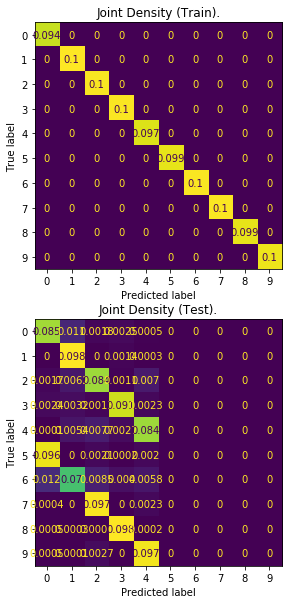

In [50]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

cm_tr = joint_density(y_tr, y_tr_orig, num_classes=10)
cm_te = joint_density(preds, y_te, num_classes=10)

plot_confusion(cm_tr, ax=axs[0], display_labels=None)
axs[0].set_title(f'Joint Density (Train).');
plot_confusion(cm_te, ax=axs[1], display_labels=None)
axs[1].set_title(f'Joint Density (Test).');